In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
import numpy as np
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

C:\Users\mhme2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mhme2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\mhme2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data=pd.read_csv("international_matches.csv")
data.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


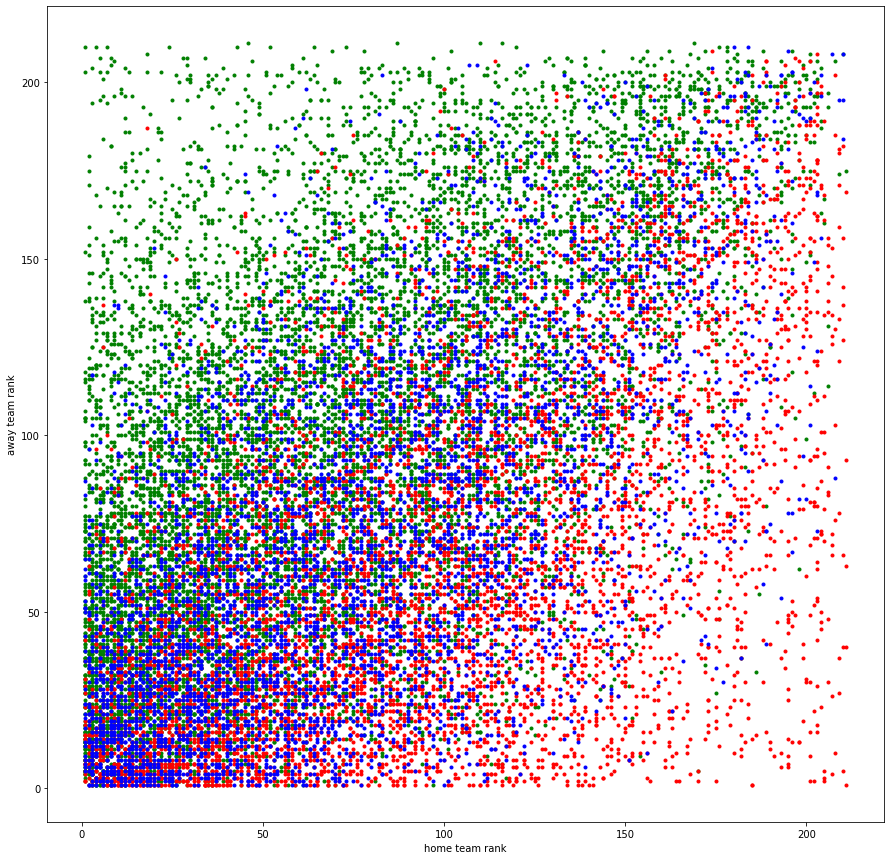

(23921, 25)


In [3]:
plt.figure(figsize=(15,15))
plt.scatter(data[data['home_team_result']=='Win']['home_team_fifa_rank'],data[data['home_team_result']=='Win']['away_team_fifa_rank'],color='green',marker='.')
plt.scatter(data[data['home_team_result']=='Lose']['home_team_fifa_rank'],data[data['home_team_result']=='Lose']['away_team_fifa_rank'],color='red',marker='.')
plt.scatter(data[data['home_team_result']=='Draw']['home_team_fifa_rank'],data[data['home_team_result']=='Draw']['away_team_fifa_rank'],color='blue',marker='.')
plt.xlabel('home team rank')
plt.ylabel('away team rank')
plt.show()
print(data.shape)
#home team win: green dots home team lose: red dots home team draw: blue dots

In [4]:
#remove the rows with home_team_total_fifa_points equal to 0
data=data[data['home_team_total_fifa_points']!=0]
data=data[data['away_team_total_fifa_points']!=0]
print("Data shape after removing junk rows: ", data.shape)
data= data[['home_team','away_team','home_team_fifa_rank','away_team_fifa_rank','home_team_total_fifa_points'
,'away_team_total_fifa_points','home_team_result']]
features=torch.tensor(data[['home_team_fifa_rank','away_team_fifa_rank','home_team_total_fifa_points','away_team_total_fifa_points']].values,dtype=torch.float)
print(features)
#normalize the features
M = features.mean(dim=0)                                     #M is a vector of means of each column
features -= M        
R = features.max(dim=0).values - features.min(dim=0).values  #R is a vector of ranges of each column
features /= R
print("Features: ", features)
labels=torch.tensor(pd.get_dummies(data['home_team_result']).values)  #converting the labels to one-hot encoding
print("Labels", labels)

Data shape after removing junk rows:  (9594, 25)
tensor([[ 114.,  158.,  260.,  112.],
        [ 120.,  129.,  245.,  208.],
        [ 108.,   88.,  298.,  364.],
        ...,
        [  28.,   60., 1526., 1387.],
        [  23.,   35., 1553., 1499.],
        [  29.,   32., 1519., 1500.]])
Features:  tensor([[ 0.1496,  0.3416, -0.2518, -0.3112],
        [ 0.1782,  0.2035, -0.2588, -0.2668],
        [ 0.1210,  0.0083, -0.2343, -0.1947],
        ...,
        [-0.2599, -0.1250,  0.3335,  0.2783],
        [-0.2837, -0.2441,  0.3459,  0.3301],
        [-0.2552, -0.2584,  0.3302,  0.3305]])
Labels tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1]], dtype=torch.uint8)


In [5]:
# creat a Dataset class to load the data in batches
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,features,labels):
        self.features=features
        self.labels=labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self,index):
        return self.features[index],self.labels[index]

In [6]:
#spliting the data into train and test
train_dataset,test_dataset=torch.utils.data.random_split(CustomDataset(features,labels),[int(0.75*len(features)),len(features)-int(0.75*len(features))])

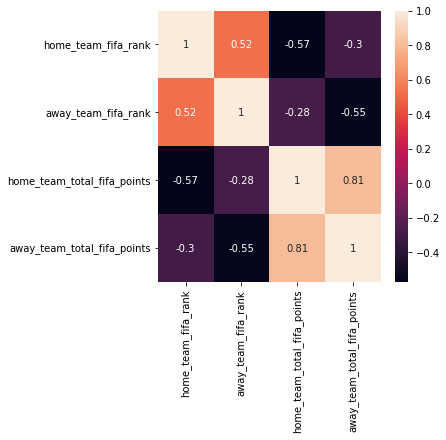

In [7]:
#correlation heatmap between the features
plt.figure(figsize=(5,5))
seaborn.heatmap(data[['home_team_fifa_rank','away_team_fifa_rank','home_team_total_fifa_points','away_team_total_fifa_points']].corr(),annot=True)
plt.show()

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
#building the model structure
class neural_network(nn.Module):
    def __init__(self):
        super(neural_network,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3))
    def forward(self, x):
        logits = self.linear_relu_stack(x.float())
        output = torch.softmax(logits,dim=-1)
        return output

model=neural_network().to(device)
print(model)

neural_network(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


In [10]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1)

train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=64,shuffle=True)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, torch.argmax(y,dim=1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 50 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        #     print(f"gradient: {model.linear_relu_stack[0].weight.grad[0][0]}")

def test_loop(model, loss_fn,  test_losses , train_losses):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct, train_loss = 0, 0, 0
    # compute the loss and accuracy on the test set
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, torch.argmax(y,dim=1)).item()
            correct += (pred.argmax(1) == torch.argmax(y,dim=1)).type(torch.float).sum().item()


    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    test_loss, correct, train_loss = 0, 0, 0
    # compute the loss and accuracy on the train set
    with torch.no_grad():
        for X, y in train_dataloader:
            pred = model(X)
            train_loss += loss_fn(pred, torch.argmax(y,dim=1)).item()
            correct += (pred.argmax(1) == torch.argmax(y,dim=1)).type(torch.float).sum().item()
    train_loss /= num_batches
    train_losses.append(train_loss)
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 55.9%, Avg loss: 0.995871 

Train Error: 
 Accuracy: 56.9%, Avg loss: 0.988793 


Epoch 2
-------------------------------
Test Error: 
 Accuracy: 56.6%, Avg loss: 0.967944 

Train Error: 
 Accuracy: 57.5%, Avg loss: 0.957881 


Epoch 3
-------------------------------
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.981817 

Train Error: 
 Accuracy: 56.5%, Avg loss: 0.970184 


Epoch 4
-------------------------------
Test Error: 
 Accuracy: 56.5%, Avg loss: 0.965076 

Train Error: 
 Accuracy: 57.5%, Avg loss: 0.958176 


Epoch 5
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 0.990517 

Train Error: 
 Accuracy: 54.8%, Avg loss: 0.989360 


Epoch 6
-------------------------------
Test Error: 
 Accuracy: 53.3%, Avg loss: 0.992869 

Train Error: 
 Accuracy: 54.9%, Avg loss: 0.981877 


Epoch 7
-------------------------------
Test Error: 
 Accuracy: 57.1%, Avg loss: 0.967986 

Train Error: 
 Accuracy: 57.2%, 

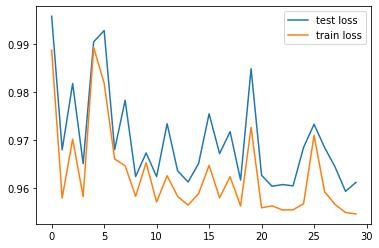

In [11]:
epochs = 30
test_losses=[]
train_losses=[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(model, loss_fn, test_losses , train_losses)
    print()
# plot the loss
plt.plot(test_losses,label='test loss')
plt.plot(train_losses,label='train loss')
plt.legend()
plt.show()

In [12]:
ir_rk   , ir_pts    = 20, 1564
eng_rk  , eng_pts   = 5, 1728
wales_rk, wales_pts = 19, 1569
us_rk   , us_pts    = 16, 1627
ir_rk -= M[0]
ir_pts -= M [2]
eng_rk -= M [1]
eng_pts -= M [3]
wales_rk -= M [1]
wales_pts -= M [3]
us_rk -= M [1]
us_pts -= M [3]
ir_rk /= R[0]
ir_pts /= R [2]
eng_rk /= R [1]
eng_pts /= R [3]
wales_rk /= R [1]
wales_pts /= R [3]
us_rk /= R [1]
us_pts /= R [3]
################################################
res = ["lose", "draw", "win"]
england_prob = model(torch.tensor([ir_rk,eng_rk,ir_pts,eng_pts], dtype=torch.float))[2] #win probability of iran against england
print(f"win probability of IR vs england: {england_prob.item():.2f}")
wales_prob = model(torch.tensor([ir_rk,wales_rk,ir_pts,wales_pts], dtype=torch.float))[2]  #win probability of iran against wales
print(f"win probability of IR vs wales: {wales_prob.item():.2f}")
us_prob = model(torch.tensor([ir_rk,us_rk,ir_pts,us_pts], dtype=torch.float))[2]         #win probability of iran against us
print(f"win probability of IR vs us: {us_prob.item():.2f}")

win probability of IR vs england: 0.27
win probability of IR vs wales: 0.58
win probability of IR vs us: 0.49
